# Computing gradients in parallel with PennyLane-Braket

A central feature of the Amazon Braket SV1 simulator is that is can execute multiple circuits sent from PennyLane in parallel. This is crucial for scalable optimization, where each training step creates lots of variations of a circuit which need to be executed. 

This tutorial will explain the importance of this feature and allow you to benchmark it yourself.

## Why is the training of circuits so expensive?

Quantum-classical hybrid optimization of quantum circuits is the workhorse algorithm of near-term quantum computing. It is not only fundamental for training variational quantum circuits but also more broadly for applications like quantum chemistry, quantum machine learning and, of course, for applications in "vanilla" quantum optimization. Today’s most powerful optimization algorithms rely on the efficient computation of gradients—which tell us how to adapt parameters a little bit at a time to improve the algorithm. 

Training quantum circuits is tough! Each step during optimization requires evaluation of the circuit gradient. Calculating the gradient involves multiple device executions: for each trainable parameter we must execute our circuit on the device typically [more than once](https://pennylane.ai/qml/glossary/parameter_shift.html). Reasonable applications involve many trainable parameters (just think of a classical neural net with millions of tunable weights). The result is a huge number of device executions for each optimization step.


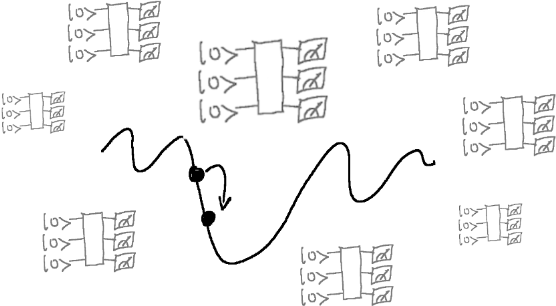

In the ``braket.local.qubit`` device, gradients are calculated in PennyLane through sequential device executions—in other words, all these circuits have to wait in the same queue until they can be evaluated. This approach is simpler, but quickly becomes slow as we scale the number of parameters. Moreover, as the number of qubits, or "width", of the circuit is scaled, each device execution will slow down and eventually become a noticeable bottleneck. In short—**the future of training quantum circuits relies on high-performance remote simulators and hardware devices that are highly parallelized**. 

Fortunately, Amazon Braket provides a solution for scalable quantum circuit training with the SV1 simulator. The SV1 simulator is a high-performance state vector simulator that is designed with parallel execution in mind. Together with PennyLane, we can use SV1 to run in parallel all the circuits needed to compute a gradient!

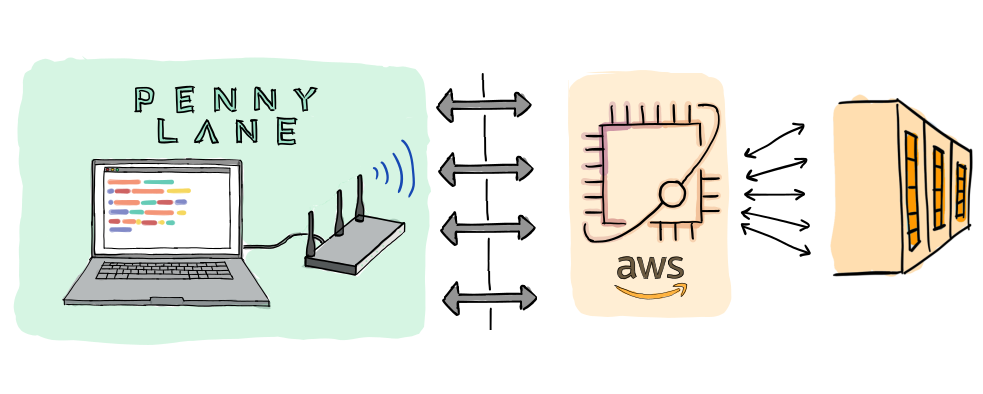

## Loading the SV1 device

Let's load Braket's SV1 simulator in PennyLane with 25 qubits. Further details on loading Braket devices are provided in the [first tutorial](./0_Getting_started.ipynb). We begin with the standard imports and specification of the bucket and ARN:

In [1]:
import pennylane as qml
from pennylane import numpy as np

qml.enable_tape()
wires = 25

# Please enter the S3 bucket you created during onboarding
# (or any other S3 bucket starting with 'amazon-braket-' in your account) in the code below

my_bucket = f"amazon-braket-Your-Bucket-Name" # the name of the bucket
my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

We've also enabled [tape mode](https://pennylane.readthedocs.io/en/stable/code/qml_tape.html) in PennyLane using ``qml.enable_tape()`` to unlock the latest features.

Recall that all remote simulators and hardware on Braket are accessed through PennyLane using the ``braket.aws.qubit`` device name. The specific remote device is set using the ``device_arn`` argument.

In [2]:
dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=wires,
    s3_destination_folder=s3_folder,
    parallel=True,
)

dev_local = qml.device("braket.local.qubit", wires=wires)

Note the ``parallel=True`` argument in ``dev_remote``. This setting allows us to unlock the power of parallel execution on SV1 for gradient calculations. The local Braket simulator has also been loaded for comparison.

## Benchmarking a circuit evaluation

We will now compare the execution time for the remote and local Braket devices. Our first step is to create a simple circuit:

In [3]:
def circuit(params):
    for i in range(wires):
        qml.RX(params[i], wires=i)
    for i in range(wires):
        qml.CNOT(wires=[i, (i + 1) % wires])
    return qml.expval(qml.PauliZ(wires - 1))

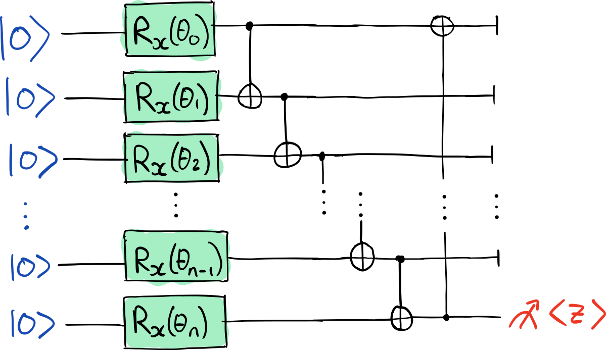

In this circuit, each of the 25 qubits has a controllable rotation. A final block of two-qubit CNOT gates is added to entangle the qubits. Overall, this circuit has 25 trainable parameters. Although not particularly relevant for practical problems, we can use this circuit as a testbed in our comparison of the remote and local devices.

The next step is to convert the above circuit into a PennyLane QNode, which binds the circuit to a device for execution.

In [4]:
qnode_remote = qml.QNode(circuit, dev_remote)
qnode_local = qml.QNode(circuit, dev_local)

<div class="alert alert-block alert-info">
    <b>Note</b> The above uses <code>qml.QNode</code> to convert the circuit. In previous tutorials, you may have seen the <code>@qml.qnode()</code> decorator being used. These approaches are interchangeable, but we use <code>qml.QNode</code> here because it allows us to pair the same circuit to different devices.
</div>

Let's now compare the execution time between the two devices:

In [5]:
import time

params = np.random.random(wires)

The following cell will result in 1 circuit being executed on SV1.

In [6]:
t_0_remote = time.time()

qnode_remote(params)

t_1_remote = time.time()

In [7]:
t_0_local = time.time()

qnode_local(params)

t_1_local = time.time()

In [8]:
print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)
print("Execution time on local device (seconds):", t_1_local - t_0_local)

Execution time on remote device (seconds): 3.8534095287323
Execution time on local device (seconds): 16.776463270187378


Nice! These timings highlight the advantage of using SV1 for simulations with large qubit numbers. In general, simulation times scale exponentially with the number of qubits, but SV1 is highly optimized and running on AWS remote servers. This allows SV1 to outperform the local simulator in this 25-qubit example. The time you see for the remote device will also depend on factors such as your distance to AWS servers.

<div class="alert alert-block alert-info">
<b>Note</b> Given these timings, why would anyone want to use the local simulator? You should consider using the local simulator when your circuit has few qubits. In this regime, the latency times of communicating the circuit to AWS dominate over simulation times, allowing the local simulator to be faster.
</div>

## Benchmarking gradient calculations

Now let us compare the gradient-calculation times between the two devices. Remember that when loading the remote device, we set ``parallel=True``. This allows the multiple device executions required during gradient calculations to be performed in parallel on SV1, so we expect the remote device to be much faster.

In [9]:
d_qnode_remote = qml.grad(qnode_remote)
d_qnode_local = qml.grad(qnode_local)

The following cell will result in 51 circuits being executed (in parallel) on SV1. We must execute the circuit twice to evaluate the partial derivative with respect to each parameter. Hence, for 25 parameters there are 50 circuit executions. The final circuit execution is due to a "forward pass" evaluation of the QNode before the gradient is calculated.

In [10]:
t_0_remote_grad = time.time()

d_qnode_remote(params)

t_1_remote_grad = time.time()

<div class="alert alert-block alert-warning">
<b>Caution:</b> Depending on your hardware, running the following cell can take 15 minutes or longer. Only uncomment it if you are happy to wait.
</div>

In [11]:
# t_0_local_grad = time.time()

# d_qnode_local(params)

# t_1_local_grad = time.time()

In [12]:
print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)
# print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)

Gradient calculation time on remote device (seconds): 29.94787311553955


If you had the patience to run the local device, you will see times of around 15 minutes or more! Compare this to less than a minute spent calculating the gradient on SV1. This provides a powerful lesson in parallelization.

What if we had run on SV1 with ``parallel=False``? It would have taken around 3 minutes—still faster than a local device, but much slower than running SV1 in parallel.

<div class="alert alert-block alert-info">
<b>What's next?</b> Look into some applications, for example how to solve 
<a href="./2_Graph_optimization_with_QAOA.ipynb">graph</a> or <a href="./3_Quantum_chemistry_with_VQE.ipynb">chemistry</a> problems with PennyLane and Braket.
</div>